In [ ]:
from google.colab import files
uploaded = files.upload()


In [ ]:
import tensorflow as tf

# Set constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load training dataset FIRST (to get class names)
raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"  # for multi-class classification
)

# Preview class names
class_names = raw_train_ds.class_names
print("Classes detected:", class_names)


Found 1034 files belonging to 3 classes.
Classes detected: ['angular_leaf_spot', 'bean_rust', 'healthy']


In [ ]:
from tensorflow.keras import layers

# Data augmentation only for training
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Load validation and test datasets
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data/val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# Apply augmentation to training data
train_ds = raw_train_ds.map(lambda x, y: (data_augmentation(x), y),
                            num_parallel_calls=tf.data.AUTOTUNE)

# Optimize all datasets
train_ds = train_ds.shuffle(1000).cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

print("Datasets ready for training!")


Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.
Datasets ready for training!


In [ ]:
#preview a batch
for images, labels in train_ds.take(1):
    print("Train batch shape:", images.shape, labels.shape)


Train batch shape: (32, 224, 224, 3) (32, 3)


In [ ]:
from tensorflow.keras.applications import MobileNetV3Large

# Load the base model with pretrained ImageNet weights
base_model = MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,   # Don't include the original classification head
    weights='imagenet'
)

# Freeze base model layers so only new head is trainable
base_model.trainable = False


In [ ]:
from tensorflow.keras import layers, Model

# Get number of classes from earlier
NUM_CLASSES = len(class_names)

# Add custom layers on top of base model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

# Combine base and new head
model = Model(inputs=base_model.input, outputs=output)


In [ ]:
#complie modal
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
#view the modal summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation_20[0]… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu_19[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation_20[0]… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_20[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 2,999,235 (11.44 MB)

 Trainable params: 2,883 (11.26 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [ ]:
#define callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Save the best model only
checkpoint_cb = ModelCheckpoint(
    "best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

# Stop if no improvement after 3 epochs
earlystop_cb = EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True,
    verbose=1
)


In [ ]:
# Fit the model on the training set, validating on the val set
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3845 - loss: 1.3715
Epoch 1: val_accuracy improved from -inf to 0.75188, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.3879 - loss: 1.3627 - val_accuracy: 0.7519 - val_loss: 0.6138
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7044 - loss: 0.6638
Epoch 2: val_accuracy improved from 0.75188 to 0.81203, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7051 - loss: 0.6627 - val_accuracy: 0.8120 - val_loss: 0.4470
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8131 - loss: 0.4976
Epoch 3: val_accuracy improved from 0.81203 to 0.87218, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8131 - loss: 0.4973 - val_accuracy: 0.8722 - val_loss: 0.3618
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8180 - loss: 0.4411
Epoch 4: val_accuracy improved from 0.87218 to 0.88722, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8184 - loss: 0.4408 - val_accuracy: 0.8872 - val_loss: 0.3251
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8688 - loss: 0.3724
Epoch 5: val_accuracy did not improve from 0.88722
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8687 - loss: 0.3724 - val_accuracy: 0.8872 - val_loss: 0.3133
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8669 - loss: 0.3586
Epoch 6: val_accuracy improved from 0.88722 to 0.89474, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8670 - loss: 0.3588 - val_accuracy: 0.8947 - val_loss: 0.2791
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8854 - loss: 0.3239
Epoch 7: val_accuracy improved from 0.89474 to 0.90226, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8855 - loss: 0.3239 - val_accuracy: 0.9023 - val_loss: 0.2686
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8924 - loss: 0.2934
Epoch 8: val_accuracy did not improve from 0.90226
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8924 - loss: 0.2936 - val_accuracy: 0.9023 - val_loss: 0.2629
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8936 - loss: 0.2812
Epoch 9: val_accuracy did not improve from 0.90226
33/33 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8936 - loss: 0.2813 - val_accuracy: 0.8947 - val_loss: 0.2603
Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9141 - loss: 0.2541
Epoch 10: val_accuracy did not improve from 0.90226
33/33 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9140 - loss: 0.2545 - val_accuracy: 0.8947 - val_loss: 0.2541
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 7.


In [ ]:
# Evaluate how well the model performs on completely unseen test data
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step - accuracy: 0.8969 - loss: 0.2808
Test accuracy: 0.8984


In [ ]:
files.download("best_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

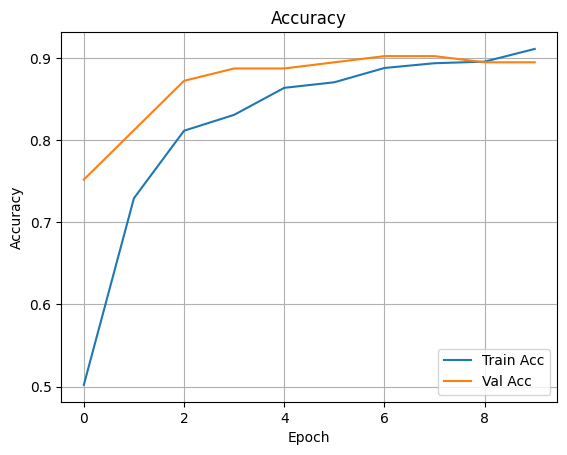

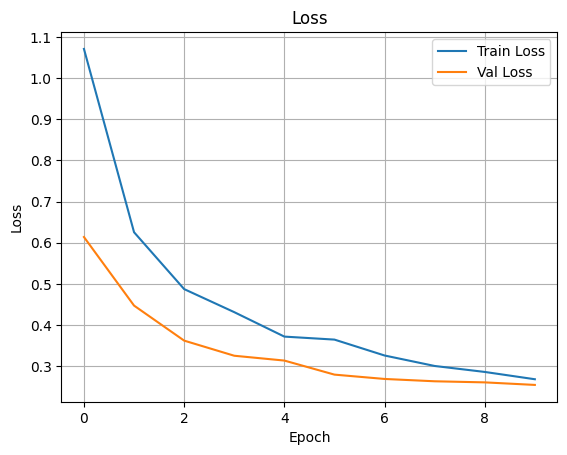

In [ ]:
#visualize training progress (accuraccy and loss)
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Model Optimization

In [ ]:
# Save in the newer Keras format
model.save("best_model.keras")


In [ ]:
from tensorflow.keras.models import load_model

# Reload using the new format
model = load_model("best_model.keras")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Convert to basic TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save it
with open("model_fp32.tflite", "wb") as f:
    f.write(tflite_model)

print("Baseline TFLite model saved as model_fp32.tflite")


Saved artifact at '/tmp/tmp_3bpc6df'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140492021165392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492030009680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492030016400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492021154064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492030002576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492030010256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492030009296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492030017168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492030016976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492030016592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1404919284053

In [ ]:
# Create a converter and enable dynamic range quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_quant_model = converter.convert()

# Save the quantized model
with open("model_quant.tflite", "wb") as f:
    f.write(tflite_quant_model)

print("✅ Quantized TFLite model saved as model_quant.tflite")


Saved artifact at '/tmp/tmplmpzaa6g'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140492021165392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492030009680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492030016400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492021154064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492030002576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492030010256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492030009296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492030017168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492030016976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492030016592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1404919284053

In [ ]:
#comparing file sizes
import os

fp32_size = os.path.getsize("model_fp32.tflite") / 1024
quant_size = os.path.getsize("model_quant.tflite") / 1024

print(f"Baseline model size: {fp32_size:.2f} KB")
print(f"Quantized model size: {quant_size:.2f} KB")


Baseline model size: 11620.27 KB
Quantized model size: 3199.10 KB


In [ ]:
# INT8 Quantization

In [ ]:
# This function yields batches of images (without labels) from your training data.
# It is used during quantization to calibrate the activations and weights.
def representative_data_gen():
    # Go through a few batches (you can adjust the .take(100) to more/less)
    for images, _ in train_ds.take(100):
        # Ensure the images are in float32 (as required)
        yield [tf.cast(images, tf.float32)]


In [ ]:
# Create a TFLite converter from the trained Keras model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable the default optimization strategy (includes quantization)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Provide the representative dataset generator we defined above
converter.representative_dataset = representative_data_gen

# Specify that we want FULL integer quantization (not mixed types)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Set both input and output types to int8 — this ensures full end-to-end INT8
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8


In [ ]:
# Perform the conversion — this will return a TFLite model as a byte string
tflite_int8_model = converter.convert()

# Save the converted model to a .tflite file
with open("model_int8.tflite", "wb") as f:
    f.write(tflite_int8_model)

print("✅ Full INT8 quantized model saved as model_int8.tflite")


Saved artifact at '/tmp/tmpbgvark_w'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140492021165392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492030009680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492030016400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492021154064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492030002576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492030010256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492030009296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492030017168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492030016976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140492030016592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1404919284053

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✅ Full INT8 quantized model saved as model_int8.tflite


In [ ]:
#downloading the model
from google.colab import files
files.download("model_int8.tflite")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>